In [83]:
import numpy as np

from mpl_toolkits.mplot3d import axes3d, Axes3D 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

<h1 style="text-align:center">Proyecto 3: Treecode Paralelo </h1>
<h2 style="text-align:center"> Camilo Valenzuela  </h2> 
<hr> 
Basado en el código de **Rio Yokota** *Boston University*

# Problema

Resolver un problema del tipo N-Body, donde se busca calcular el **pontencial** de **$N$** que interactuan con **$M$** partículas *(generalmente las particulas interactuan entre sí por lo que $M=N$)*.

**Ejemplo:**
Simulaciones de Galaxias
<img src="img/galaxycollision.jpg" style="height: auto; 
    width: auto; 
    max-width: 500px; 
    max-height: 500px;"/>
    
El problema a tratar en este proyecto es un **N-Body Problem** donde el potencial de la partícula está dado por
$$ \phi(x_i) = \sum_{j=0}^N \frac{m_j}{r} \text{ con } r = | x_i - x_j |$$

Calcular este potencial de forma directa tiene un costo computacional $O(N^2)$, para acelerar este cálculo se puede utilizar **Treecode**

<hr>

# Treecode

El algoritmo de Treecode busca bajar la complejidad de los problemas de interacción de particulas de $O(N^2)$ a $O\left(N log(N)\right)$, para lograrlo este algoritmo se puede dividir en varios pasos:
1. Construir un árbol dinámico para dividir el dominio del problema en cajas dependiendo de la distribución de las partículas. <img src="img/cajas.png" style="height: auto; 
    width: auto; 
    max-width: 400px; 
    max-height: 400px;"/>
2. Calcular los multipolos de cada utilizando las particulas que se encuentran en ella.

3. Llevar los multipolos desde las cajas inferiores hacia cajas más arriba en el arbol.
<img src="img/m2m.png" style="height: auto; 
    width: auto; 
    max-width: 400px; 
    max-height: 400px;"/>
4. Calcular el potencial de la particula target con las cajas o partículas dependiendo de un criterio de aceptación.
<img src="img/evaluation.jpg" style="height: auto; 
    width: auto; 
    max-width: 400px; 
    max-height: 400px;"/>
    
<hr>

# Implementación del algoritmo

* El trabajo fue realizado sobre el código en **C/C++** de **Rio Yokota** *(step01.c, step06.c)*.

* Para facilitar la ejecución de los ejemplos y la presentación se  utilizó **Cython** para hacer las llamadas al código en C/C++ directamente desde python.

## Ejecutando las funciones
* Se compila el código en *Cython*
```bash 
python setup.py build_ext --inline
```
* Con el modulo compilado se puede importar a python y correr las funciones

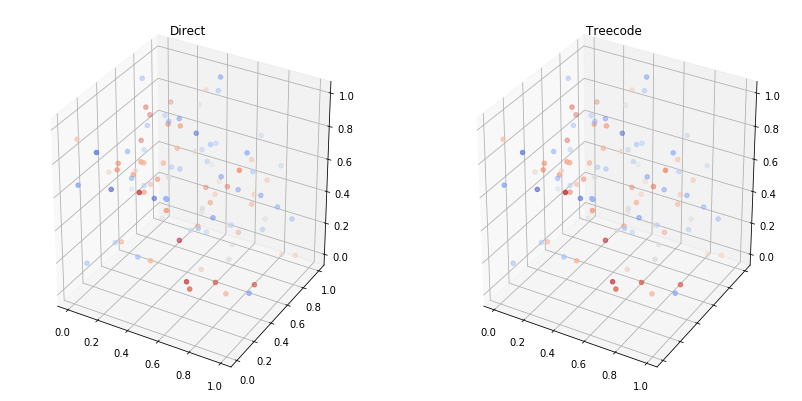

In [84]:
#Custom Module
import fastree

#Random particles and masses 
N= 100
p = np.random.rand(N,3)
m = np.random.rand(N)

#Treecode parameters
eps=1e-10
theta = 0.5
max_n = 10

#Running direct and secuential treecode
direct = fastree.direct_sum(p,m,eps)
treecode = fastree.treecode(p,m,eps,theta,max_n)

#Plotting 3d
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,7),subplot_kw=dict(projection='3d'),sharex=True,sharey=True)
scatter=ax1.scatter(p[:,0],p[:,1],p[:,2],c=direct, cmap=cm.coolwarm)
scatter=ax2.scatter(p[:,0],p[:,1],p[:,2],c=treecode,cmap=cm.coolwarm)
ax1.set_title("Direct")
ax2.set_title("Treecode")

plt.show()

Se puede observar que ambos algoritmos obtienen resultados parecidos (colores de cada punto en el plot), además podemos medir el tiempo en que corre los algoritmos

In [85]:
import time
#Random particles and masses 
direct_t = []
treecode_t = []
particles = np.arange(100,10001,500)
for N in particles:
    p = np.random.rand(N,3)
    m = np.random.rand(N)
    
    d_t = time.time()
    fastree.direct_sum(p,m,eps)
    d_t = time.time() - d_t
    direct_t.append(d_t)
    
    t_t = time.time()
    fastree.treecode(p,m,eps,theta,max_n)
    t_t = time.time() - t_t
    treecode_t.append(t_t)

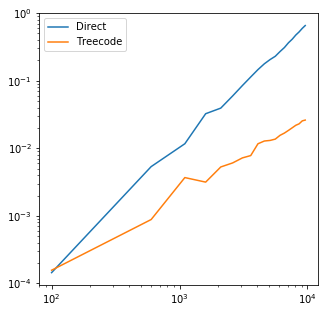

In [86]:
plt.figure(figsize=(5,5))
plt.loglog(particles,direct_t)
plt.loglog(particles,treecode_t)
plt.legend(["Direct","Treecode"])
plt.show()

# Implementación Paralela

En este proyecto se trabajó con paralelización dentro del mismo *Nodo*. Se realizaron dos implementaciones
- La primera utilizando **OpenMP** a varios niveles.
- La segunda se realizó una pequeña implementación con **pthreads**

## OpenMP
La implementación principal se realizó utilizando OpenMP
- Ventajas
    1. Alto Nivel
    2. Simple de utilizar
    3. Se ejecuta de forma secuencial si no hay más de 1 thread.
- Desventajas:
    1. No se tiene mucho control
    2. Utiliza mucha exclusión en sectiones que no necesita
    
### Pragmas
Los pragmas se utilizan para controlar el comportamiento del compilador. **OpenMP** utiliza estos pragmas para generar el código paralelo.

```c++
    #pragma omp parallel //Indica que el código puede ser ejecutado
                     // de forma paralela
    #pragma omp single
    {
        //Sección que corre sólo un thread
    }

    #pragma omp task //Se genera una tarea 
    {
        //Tarea que puede ser ejecutada de forma paralela
    }

    #pragma omp taskwait //Espera a que se terminen todas las tareas



    #pragma omp for //Ejecuta el ciclo for de forma paralela
    for(int i = 0; i < N; i++){
           //Proceso
    }
```

## Implementación

Se dividió la paralelización en tres partes
1. Evaluación del potencial (Con multipolos calculados)
2. Cálculo de los Multipolos (P2M)
3. Calcular Multipolos de los padres (M2M)

### Evaluación del Potencial
Cómo la evaluación del potencial solo depende del target, simplemente se necesitó agregar el pragma al ciclo
```c++
    #pragma omp for
    for(int i = 0; i < N; i++){
           evaluate(target)
    }
```

### Cálculo de Multipolos (P2M)
Originalmente el cálculo de los Multipolos se realizaba una búsqueda a travez del árbol hasta llegar a las hojas del primer nivel, donde se realizaba el cálculo.

Para paralelizarlo se utilizó la misma idea recursiva, pero en vez de visitar a cada hijo se creaba una tarea (*task*) que visite los hijos.

```c++
    void getMultipole(cell *C){
        if(C != nivel inferior){
            for(int i=0; i < C-> hijos; i++){
                #pragma omp task            //Se crea una tarea por cada hijo
                getMultipole(C-> hijo[i]);  //que se ejecuta de forma paralela
            }
        }
        else{
            //Estamos en el nivel inferior
            //Se calcula el Multipolo con las partículas 
            //Que se encuentran en la caja.
        }
    }

    
    int main(){
        //Construcción Arbol
        #pragma omp parallel
        {
            #pragma omp single   //Se ejecuta en un sólo thread
            getMultipole(raiz)
            #pragma omp taskwait //Esperamos a que se acaben todas las task
            
            #pragma omp single
            //Se realiza M2M de forma secuencial
            #pragma barrier //Esperamos a que el thread termine
            
            //Se evalua el potencial
        }
    }
```

### Multipolo de los Padres (M2M)
Para el cálculo del multipolo de los padres originalmente se realizaba una búsqueda post orden en el árbol, por lo que se agregó a la función del cálculo de multipolo que realizara el M2M luego de que sus hijos terminen sus tareas.

```c++
    void getMultipole(cell *C){
        if(C != nivel inferior){
            for(int i=0; i < C-> hijos; i++){
                #pragma omp task            //Se crea una tarea por cada hijo
                getMultipole(C-> hijo[i]);  //que se ejecuta de forma paralela
            }
        }
        else{
            //Estamos en el nivel inferior
            //Se calcula el Multipolo con las partículas 
            //Que se encuentran en la caja.
        }
        #pragma omp taskwait //Esperamos que los hijos terminen las tareas
        #pragma omp critical //Necesario para mantener los mismos resultados
        //Calculo del M2M
    }
```

## Pthread
**Pthread** a diferencia de OpenMP necesita un mayor concimiento de programación paralela, pero se puede realizar un manejo más eficiente de los recursos dando un mejor rendimiento.

Para la implementación con Pthreads se realizó sólo la última evaluación del multipolo de forma paralela.

```c++
    struct thread_args{
      int thread_id;
    };
    
    void *p_evaluate(void *arg){
        thread_args args = *((thread_args*) arg);
        int i = args.thread_id;

        int start, end;
        int step = N/threads;
        start = i*step;
        end = (i+1)*step;
   
        for(i=start; i< end; i++ ) {
        cell *C = root;
        double p = -m[i] / sqrtf(pEPS2);
        evaluate(root,target,p);
        potential[i] = p;
        }
    }

    int main(){
        pthread_t td[threads];
        thread_args args[threads];
        //Construcción del Árbol

        //Calcular P2M

        //Calcular M2M

        for(i = 0; i < threads; i++){
            args[i].thread_id = i;
            pthread_create(&td[i], NULL, p_evaluate,(void *)&args[i]);
        }
            for (i = 0; i < threads; i++) {
            pthread_join(td[i], NULL);
        }
    }
```

# Experimentos

Se realizaron **dos experimentos**:
- Ejecutar los algoritmos con $N=10^6$ partículas variando la cantidad de threads
- Ejecutar los algoritmos variando la cantidad de partículas fijando la cantidad de threads.

Los experimentos se realizaron en un nodo del **CH2AD (Chile-China Astronomical Datacenter)** que cuenta con:
- 120 gb ram.
- 24 cores.

# Resultados
## Variando la cantidad de Threads
Se realizó el experimento y se calculó el tiempo de ejecución de cada algoritmo y el speedup en relación al treecode secuencial 
$$ speedup = \frac{t_{paralelo}}{t_{secuencial}} $$

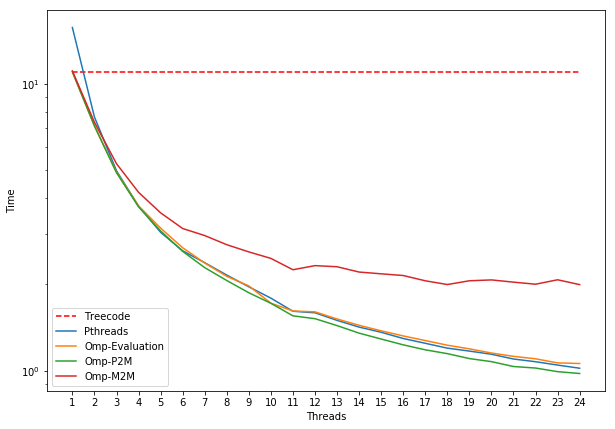

In [87]:
max_threads = 24
thread_times = np.load("times.npz")
omp_evaluation = thread_times["omp_evaluation_times"]
omp_multipole = thread_times["omp_multipole_times"]
omp_full = thread_times["omp_times"]
pthread_times = thread_times["pthread_times"]
threads = np.arange(1,max_threads+1)

treecode_t = np.ones(len(threads))*thread_times["treecode_time"] 

plt.figure(figsize=(10,7))
plt.semilogy(threads,treecode_t, '--r')
plt.semilogy(threads, pthread_times)
plt.semilogy(threads, omp_evaluation)
plt.semilogy(threads, omp_multipole)
plt.semilogy(threads, omp_full)
plt.legend(["Treecode","Pthreads","Omp-Evaluation", "Omp-P2M", "Omp-M2M"])
plt.xlabel("Threads")
plt.ylabel("Time")
plt.xticks(threads)
plt.show()

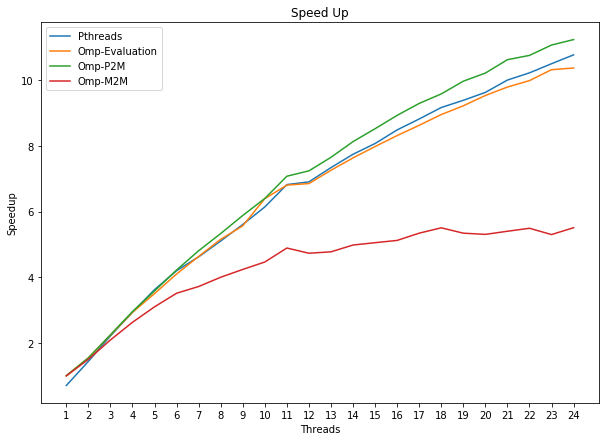

In [88]:
thread_times = np.load("times.npz")
omp_evaluation = thread_times["omp_evaluation_speedup"]
omp_multipole = thread_times["omp_multipole_speedup"]
omp_full = thread_times["omp_speedup"]
pthread_times = thread_times["pthread_speedup"]
threads = np.arange(1,max_threads+1)

plt.figure(figsize=(10,7))
plt.plot(threads, pthread_times)
plt.plot(threads, omp_evaluation)
plt.plot(threads, omp_multipole)
plt.plot(threads, omp_full)
plt.legend(["Pthreads","Omp-Evaluation", "Omp-P2M", "Omp-M2M"])
plt.xlabel("Threads")
plt.ylabel("Speedup")
plt.xticks(threads)
plt.title("Speed Up")
plt.show()

## Variando la cantidad de partículas

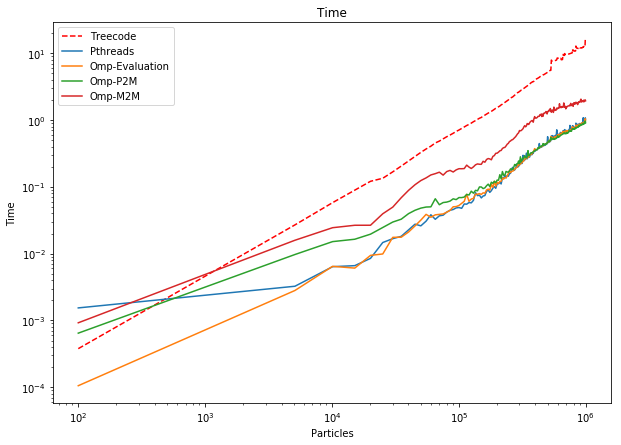

In [89]:
particles_times = np.load("particles.npz")
omp_evaluation = particles_times["omp_evaluation_times"]
omp_multipole = particles_times["omp_multipole_times"]
omp_full = particles_times["omp_times"]
pthread_times = particles_times["pthread_times"]
treecode_times = particles_times["treecode_times"]
N_list = particles_times["N_list"]

plt.figure(figsize=(10,7))
plt.loglog(N_list,treecode_times,'--r')
plt.loglog(N_list, pthread_times)
plt.loglog(N_list, omp_evaluation)
plt.loglog(N_list, omp_multipole)
plt.loglog(N_list, omp_full)
plt.legend(["Treecode","Pthreads","Omp-Evaluation", "Omp-P2M", "Omp-M2M"])
plt.xlabel("Particles")
plt.ylabel("Time")
plt.title("Time")
plt.show()

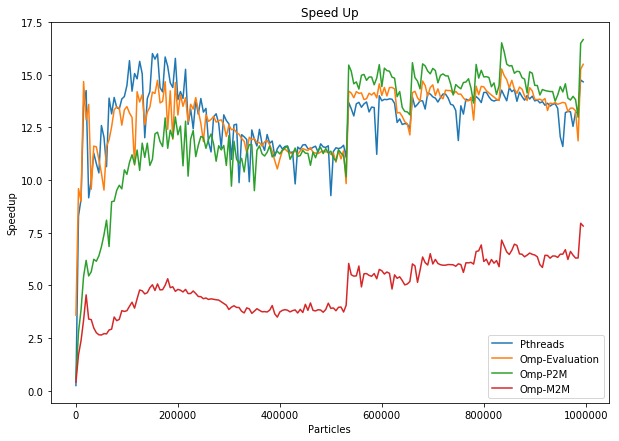

In [90]:
particles_times = np.load("particles.npz")
omp_evaluation = particles_times["omp_evaluation_speedup"]
omp_multipole = particles_times["omp_multipole_speedup"]
omp_full = particles_times["omp_speedup"]
pthread_times = particles_times["pthread_speedup"]
N_list = particles_times["N_list"]

plt.figure(figsize=(10,7))
plt.plot(N_list, pthread_times)
plt.plot(N_list, omp_evaluation)
plt.plot(N_list, omp_multipole)
plt.plot(N_list, omp_full)
plt.legend(["Pthreads","Omp-Evaluation", "Omp-P2M", "Omp-M2M"])
plt.xlabel("Particles")
plt.ylabel("Speedup")
plt.title("Speed Up")
plt.show()

# Conclusiones

1. Por los resultados obtenidos podemos decir que Treecode es un buen ejemplo de un algoritmo paralelizable.
2. OpenMP es una buena herramienta para paralelizar codigo de forma simple.
3. Al ser tan alto nivel OpenMP no realiza una paralelización tan eficiente en comparación a pthreads.
4. A mayor cantidad de particulas se puede observar un mayor speedup para los algoritmos paralelos.